# Real estate Fraud Classification

### Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
housing_df_org = pd.read_csv("C:/Users/pbyim/OneDrive/바탕 화면/시온/Data/부동산_허위매물_분류/train.csv")
housing_df = housing_df_org.copy()
housing_df.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,TRAIN_0000,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,TRAIN_0001,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,TRAIN_0002,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0
3,TRAIN_0003,현장확인,163500000.0,30000,36.3,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1


In [5]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2452 non-null   object 
 1   매물확인방식  2452 non-null   object 
 2   보증금     2452 non-null   float64
 3   월세      2452 non-null   int64  
 4   전용면적    1665 non-null   float64
 5   해당층     2223 non-null   float64
 6   총층      2436 non-null   float64
 7   방향      2452 non-null   object 
 8   방수      2436 non-null   float64
 9   욕실수     2434 non-null   float64
 10  주차가능여부  2452 non-null   object 
 11  총주차대수   1756 non-null   float64
 12  관리비     2452 non-null   int64  
 13  중개사무소   2452 non-null   object 
 14  제공플랫폼   2452 non-null   object 
 15  게재일     2452 non-null   object 
 16  허위매물여부  2452 non-null   int64  
dtypes: float64(7), int64(3), object(7)
memory usage: 325.8+ KB


In [7]:
housing_df.drop('ID', axis=1, inplace=True)

- Handling missing values

In [9]:
null_series = housing_df.isnull().sum()
null_series[null_series.values > 0]

전용면적     787
해당층      229
총층        16
방수        16
욕실수       18
총주차대수    696
dtype: int64

In [11]:
null_feature_list = list(null_series[null_series.values > 0].index)

In [13]:
housing_df[null_feature_list].describe()

,전용면적,해당층,총층,방수,욕실수,총주차대수
count,1665.000000,2223.000000,2436.000000,2436.000000,2434.000000,1756.000000
mean,27.009628,4.848403,8.052545,1.378079,1.034511,20.332574
std,7.951757,3.543348,4.920112,0.485007,0.182575,28.939900
min,17.500000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,19.800000,2.000000,4.000000,1.000000,1.000000,4.000000
50%,26.400000,4.000000,6.000000,1.000000,1.000000,10.000000
75%,32.110000,6.000000,10.000000,2.000000,1.000000,31.000000
max,49.970000,21.000000,21.000000,2.000000,2.000000,590.000000


In [15]:
import matplotlib
# 1) 폰트 설정
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'NanumGothic'
matplotlib.rcParams['font.size'] = 10                 # 폰트 크기(원하는 값)
matplotlib.rcParams['axes.unicode_minus'] = False     # - 기호 깨짐 방지

In [17]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

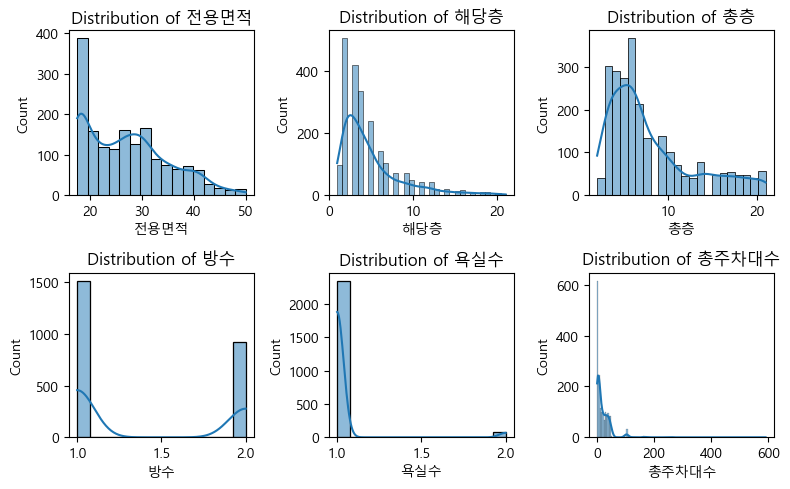

In [19]:
fig, axes = plt.subplots(figsize=(8,5), nrows=2, ncols=3)

for i, feature in enumerate(null_feature_list):
    row = i//3 ; col = i%3
    sns.histplot(housing_df[feature], kde=True, ax=axes[row][col])
    axes[row, col].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [21]:
housing_df['방수'].value_counts()

방수
1.0    1515
2.0     921
Name: count, dtype: int64

In [23]:
housing_df['욕실수'].value_counts()

욕실수
1.0    2350
2.0      84
Name: count, dtype: int64

- Fill null values of '전용면적' with mean, '방수' and '욕실수' with 1.0
- The '해당층' and '총층' are said to be float types, but in reality, they are integer units, so we round the mean value to fill
- '총주차대수' is NAN if the '주차가능여부' is '불가능', so fill it with 0.

In [26]:
housing_df['전용면적'] = housing_df['전용면적'].fillna(housing_df['전용면적'].mean())
housing_df[['방수','욕실수']] = housing_df[['방수','욕실수']].fillna(1.0)
housing_df[['해당층','총층']] = housing_df[['해당층','총층']].fillna(np.round(housing_df[['해당층','총층']].mean()))
housing_df['총주차대수'] = housing_df['총주차대수'].fillna(0)

In [28]:
housing_df.isnull().sum().sum()

0

In [32]:
housing_df.head(3)

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,현장확인,402500000.0,470000,27.009628,5.0,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,현장확인,170500000.0,200000,27.009628,3.0,4.0,남동향,2.0,1.0,불가능,0.0,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,전화확인,114000000.0,380000,27.009628,2.0,3.0,동향,1.0,1.0,불가능,0.0,0,b03oE4G3F6,A플랫폼,2024-11-28,0


In [34]:
housing_df['중개사무소'].value_counts()

중개사무소
G52Iz8V2B9    799
r82ax9M3U3     43
J52gJ2E4T6     32
H90uE4C0W5     30
b87Td0W4Y3     27
             ... 
m75Dz8P6I7      1
A21Yr4B1U8      1
g11ci7P5V1      1
D26uW0Q2N3      1
L27JO3N6S2      1
Name: count, Length: 279, dtype: int64

- Even though the '중개사무소' feature is mostly 'G52Iz8V2B9', it is uncertain if it has impact on target
- But it has too many category of 279, thus perform frequency encoding
- Later I will try model **with 중개사무소_freq** and the one without it

In [37]:
freq_map = housing_df['중개사무소'].value_counts()
housing_df['중개사무소_freq'] = housing_df['중개사무소'].map(freq_map)

- Extract year. month, date from '게재일'

In [40]:
housing_df['게재일'] = housing_df['게재일'].apply(pd.to_datetime)

housing_df['연'] = housing_df['게재일'].apply(lambda x: x.year)
housing_df['월'] = housing_df['게재일'].apply(lambda x: x.month)
housing_df['일'] = housing_df['게재일'].apply(lambda x: x.day)

housing_df = housing_df.drop(['중개사무소','게재일'], axis=1)
housing_df.head(3)

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,제공플랫폼,허위매물여부,중개사무소_freq,연,월,일
0,현장확인,402500000.0,470000,27.009628,5.0,15.0,서향,1.0,1.0,가능,40.0,96,B플랫폼,0,6,2024,10,9
1,현장확인,170500000.0,200000,27.009628,3.0,4.0,남동향,2.0,1.0,불가능,0.0,0,D플랫폼,0,2,2024,12,26
2,전화확인,114000000.0,380000,27.009628,2.0,3.0,동향,1.0,1.0,불가능,0.0,0,A플랫폼,0,19,2024,11,28


- Perform one-hot encoding to other object type features

In [43]:
print(f'Before encoding: {housing_df.shape}')
housing_df_encoded = pd.get_dummies(housing_df, drop_first=True)
print(f'After encoding: {housing_df_encoded.shape}')

Before encoding: (2452, 18)
After encoding: (2452, 36)


- Define a function to reuse data preprocessing

In [46]:
def process_housing_df(housing_df):
    housing_df['전용면적'] = housing_df['전용면적'].fillna(housing_df['전용면적'].mean())
    housing_df[['방수','욕실수']] = housing_df[['방수','욕실수']].fillna(1.0)
    housing_df[['해당층','총층']] = housing_df[['해당층','총층']].fillna(np.round(housing_df[['해당층','총층']].mean()))
    housing_df['총주차대수'] = housing_df['총주차대수'].fillna(0)

    freq_map = housing_df['중개사무소'].value_counts()
    housing_df['중개사무소_freq'] = housing_df['중개사무소'].map(freq_map)

    housing_df['게재일'] = housing_df['게재일'].apply(pd.to_datetime)

    housing_df['연'] = housing_df['게재일'].apply(lambda x: x.year)
    housing_df['월'] = housing_df['게재일'].apply(lambda x: x.month)
    housing_df['일'] = housing_df['게재일'].apply(lambda x: x.day)

    housing_df = housing_df.drop(['ID','중개사무소','게재일'], axis=1)
    return housing_df

### Model training/learning/evaluation

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [59]:
def get_scores(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:,1]
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, pred_prob)

    print(f'Confusion matrix:\n{confusion_mat}')
    print(f'Accuracy:{acc} Precision:{precision} Recall:{recall} F1-Score:{f1} AUC-Score:{auc}\n')  

def get_model_scores(models, X_train, X_test, y_train, y_test):
    for model in models:
        print(model.__class__.__name__)
        get_scores(model, X_train, X_test, y_train, y_test)

In [63]:
X = housing_df_encoded.drop('허위매물여부', axis=1)
X_2 = housing_df_encoded.drop(['중개사무소_freq','허위매물여부'], axis=1)
y = housing_df_encoded['허위매물여부']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, test_size=0.2, random_state=123)

lr_clf = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(random_state=123)
lgbm_clf = LGBMClassifier(n_estimators=1000, verbosity=-1)

models = [lr_clf, rf_clf, lgbm_clf]
get_model_scores(models, X_train, X_test, y_train, y_test)
print('Model without 중개사무소_freq')
get_model_scores(models, X_train_2, X_test_2, y_train_2, y_test_2)

LogisticRegression
Confusion matrix:
[[424   0]
 [ 67   0]]
Accuracy:0.8635437881873728 Precision:0.0 Recall:0.0 F1-Score:0.0 AUC-Score:0.6981836102506336

RandomForestClassifier


C:\Users\pbyim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix:
[[419   5]
 [ 29  38]]
Accuracy:0.9307535641547862 Precision:0.8837209302325582 Recall:0.5671641791044776 F1-Score:0.6909090909090909 AUC-Score:0.9696212334553648

LGBMClassifier
Confusion matrix:
[[417   7]
 [ 16  51]]
Accuracy:0.9531568228105907 Precision:0.8793103448275862 Recall:0.7611940298507462 F1-Score:0.816 AUC-Score:0.980005632216277

Model without 중개사무소_freq
LogisticRegression
Confusion matrix:
[[424   0]
 [ 67   0]]
Accuracy:0.8635437881873728 Precision:0.0 Recall:0.0 F1-Score:0.0 AUC-Score:0.5304491692480992

RandomForestClassifier


C:\Users\pbyim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix:
[[421   3]
 [ 35  32]]
Accuracy:0.9226069246435845 Precision:0.9142857142857143 Recall:0.47761194029850745 F1-Score:0.6274509803921569 AUC-Score:0.9379400168966489

LGBMClassifier
Confusion matrix:
[[418   6]
 [ 21  46]]
Accuracy:0.945010183299389 Precision:0.8846153846153846 Recall:0.6865671641791045 F1-Score:0.773109243697479 AUC-Score:0.9584272036046185



- Models without 중개사무소_freq performs poorer, so I will keep the feature
- We will focus more on to increase Recall rate
- Currently scores above seems unnormal

In [66]:
housing_df_encoded['허위매물여부'].value_counts()

허위매물여부
0    2154
1     298
Name: count, dtype: int64

- About 88% of target is 0, thus use stratification to split the data and try again

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

lr_clf = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(random_state=123)
lgbm_clf = LGBMClassifier(n_estimators=1000, verbosity=-1)

models = [lr_clf, rf_clf, lgbm_clf]
get_model_scores(models, X_train, X_test, y_train, y_test)

LogisticRegression
Confusion matrix:
[[431   0]
 [ 60   0]]
Accuracy:0.8778004073319755 Precision:0.0 Recall:0.0 F1-Score:0.0 AUC-Score:0.6720804331013148

RandomForestClassifier


C:\Users\pbyim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix:
[[426   5]
 [ 26  34]]
Accuracy:0.9368635437881874 Precision:0.8717948717948718 Recall:0.5666666666666667 F1-Score:0.6868686868686869 AUC-Score:0.9716550657385924

LGBMClassifier
Confusion matrix:
[[422   9]
 [  9  51]]
Accuracy:0.9633401221995926 Precision:0.85 Recall:0.85 F1-Score:0.85 AUC-Score:0.9811678267594741



- The model performances got better but logistic regression and randomforest model are still not working well
- We checked '총주차대수' column was highly skewed, try log-scale the column

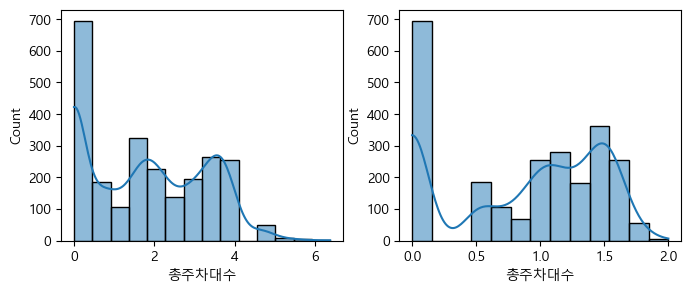

In [164]:
fig, axes = plt.subplots(figsize=(8,3), ncols=2)
sns.histplot(housing_df['총주차대수'], kde=True, ax=axes[0])
sns.histplot(np.log1p(housing_df['총주차대수']), kde=True, ax=axes[1])
plt.show()

- It is still not bell-shape but obviously got much more less skewed, thus adapt it to our data and try again

In [75]:
housing_df_encoded['총주차대수'] = np.log1p(housing_df_encoded['총주차대수'])
X = housing_df_encoded.drop('허위매물여부', axis=1)
y = housing_df_encoded['허위매물여부']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

lr_clf = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(random_state=123)
lgbm_clf = LGBMClassifier(n_estimators=1000, verbosity=-1)

models = [lr_clf, rf_clf, lgbm_clf]
get_model_scores(models, X_train, X_test, y_train, y_test)

LogisticRegression
Confusion matrix:
[[431   0]
 [ 60   0]]
Accuracy:0.8778004073319755 Precision:0.0 Recall:0.0 F1-Score:0.0 AUC-Score:0.6710363495746327

RandomForestClassifier


C:\Users\pbyim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix:
[[426   5]
 [ 25  35]]
Accuracy:0.9389002036659878 Precision:0.875 Recall:0.5833333333333334 F1-Score:0.7 AUC-Score:0.9718870843000773

LGBMClassifier
Confusion matrix:
[[422   9]
 [  9  51]]
Accuracy:0.9633401221995926 Precision:0.85 Recall:0.85 F1-Score:0.85 AUC-Score:0.9811678267594741



- We see a very slight improvement but no significant impact
- Since we aim to increase recall rate, we adapt SMOTE and retry

In [78]:
from imblearn.over_sampling import SMOTE

In [80]:
smote = SMOTE(random_state=123)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print(f'Shape of train dataset before SMOTE {X_train.shape, y_train.shape}')
print(f'Shape of test dataset after SMOTE {X_train_over.shape, y_train_over.shape}')
print(f'Distribution of label before SMOTE: {y_train.value_counts()}')
print(f'Distribution of label after SMOTE: {y_train_over.value_counts()}')

Shape of train dataset before SMOTE ((1961, 35), (1961,))
Shape of test dataset after SMOTE ((3446, 35), (3446,))
Distribution of label before SMOTE: 허위매물여부
0    1723
1     238
Name: count, dtype: int64
Distribution of label after SMOTE: 허위매물여부
0    1723
1    1723
Name: count, dtype: int64


In [82]:
lr_clf = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(random_state=123)
lgbm_clf = LGBMClassifier(n_estimators=1000, verbosity=-1)

models = [lr_clf, rf_clf, lgbm_clf]
get_model_scores(models, X_train_over, X_test, y_train_over, y_test)

LogisticRegression
Confusion matrix:
[[167 264]
 [  0  60]]
Accuracy:0.4623217922606925 Precision:0.18518518518518517 Recall:1.0 F1-Score:0.3125 AUC-Score:0.6739365815931941

RandomForestClassifier
Confusion matrix:
[[411  20]
 [ 16  44]]
Accuracy:0.9266802443991853 Precision:0.6875 Recall:0.7333333333333333 F1-Score:0.7096774193548387 AUC-Score:0.9619102861562258

LGBMClassifier
Confusion matrix:
[[418  13]
 [  7  53]]
Accuracy:0.9592668024439919 Precision:0.803030303030303 Recall:0.8833333333333333 F1-Score:0.8412698412698413 AUC-Score:0.9720417633410673



- Recall rate increased, eliminate outliers and retry
- Since it is hard to remove outliers from all features, I will use lgbm model to visualize feature importance first

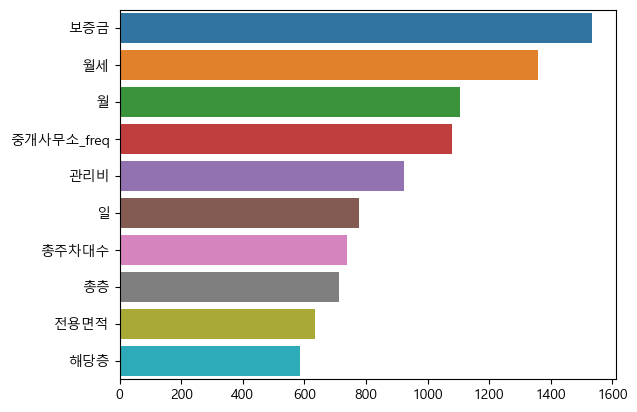

In [85]:
feature_series = pd.Series(lgbm_clf.feature_importances_, index=X.columns)
feature_series = feature_series.sort_values(ascending=False)[:10]

sns.barplot(x=feature_series, y=feature_series.index)
plt.show()

In [87]:
def get_outlier(df, column, weight=1.5):
    fraud = df[df['허위매물여부']==1][column]
    quantile25 = np.percentile(fraud.values, 25)
    quantile75 = np.percentile(fraud.values, 75)

    iqr = weight * (quantile75-quantile25)
    lower_bound = quantile25-iqr
    upper_bound = quantile75+iqr

    outlier_idx = fraud[(fraud<lower_bound) | (fraud>upper_bound)].index
    return outlier_idx

In [89]:
outlier_idx_1 = get_outlier(housing_df, '월세')
outlier_idx_2 = get_outlier(housing_df, '보증금')
print(f'월세 vs 허위매물 outlier: {outlier_idx_1}')
print(f'보증금 vs 허위매물 outlier: {outlier_idx_2}')

월세 vs 허위매물 outlier: Index([], dtype='int64')
보증금 vs 허위매물 outlier: Index([], dtype='int64')


In [91]:
outlier_idx_3 = get_outlier(housing_df, '관리비')
outlier_idx_4 = get_outlier(housing_df, '중개사무소_freq')
print(f'관리비 vs 허위매물 outlier: {outlier_idx_3}')
print(f'중개사무소_freq vs 허위매물 outlier: {outlier_idx_4}')

관리비 vs 허위매물 outlier: Index([], dtype='int64')
중개사무소_freq vs 허위매물 outlier: Index([229, 590, 877, 1274, 1389, 1469, 1842, 2241], dtype='int64')


In [93]:
housing_df.drop(outlier_idx_4, axis=0, inplace=True)
housing_df_encoded = pd.get_dummies(housing_df, drop_first=True)

In [119]:
housing_df_encoded['총주차대수'] = np.log1p(housing_df_encoded['총주차대수'])
X = housing_df_encoded.drop('허위매물여부', axis=1)
y = housing_df_encoded['허위매물여부']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

smote = SMOTE(random_state=123)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

lr_clf = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(random_state=123)
lgbm_clf = LGBMClassifier(n_estimators=1000, verbosity=-1)

models = [lr_clf, rf_clf, lgbm_clf]
get_model_scores(models, X_train_over, X_test, y_train_over, y_test)

LogisticRegression
Confusion matrix:
[[167 264]
 [  0  60]]
Accuracy:0.4623217922606925 Precision:0.18518518518518517 Recall:1.0 F1-Score:0.3125 AUC-Score:0.6739365815931941

RandomForestClassifier
Confusion matrix:
[[414  17]
 [ 15  45]]
Accuracy:0.9348268839103869 Precision:0.7258064516129032 Recall:0.75 F1-Score:0.7377049180327869 AUC-Score:0.9668020108275328

LGBMClassifier
Confusion matrix:
[[418  13]
 [  8  52]]
Accuracy:0.9572301425661914 Precision:0.8 Recall:0.8666666666666667 F1-Score:0.832 AUC-Score:0.9719644238205722



- Performance got poorer, thus I will not remove outliers.
- I will use LGBM model which works the best, revise data processing function and move on to hyperparameter tuning

In [99]:
def process_housing_df(housing_df):
    housing_df['전용면적'] = housing_df['전용면적'].fillna(housing_df['전용면적'].mean())
    housing_df[['방수','욕실수']] = housing_df[['방수','욕실수']].fillna(1.0)
    housing_df[['해당층','총층']] = housing_df[['해당층','총층']].fillna(np.round(housing_df[['해당층','총층']].mean()))
    housing_df['총주차대수'] = housing_df['총주차대수'].fillna(0)

    freq_map = housing_df['중개사무소'].value_counts()
    housing_df['중개사무소_freq'] = housing_df['중개사무소'].map(freq_map)

    housing_df['게재일'] = housing_df['게재일'].apply(pd.to_datetime)

    housing_df['연'] = housing_df['게재일'].apply(lambda x: x.year)
    housing_df['월'] = housing_df['게재일'].apply(lambda x: x.month)
    housing_df['일'] = housing_df['게재일'].apply(lambda x: x.day)

    housing_df['총주차대수'] = np.log1p(housing_df['총주차대수'])
    housing_df = housing_df.drop(['ID','중개사무소','게재일'], axis=1)
    return housing_df

In [149]:
housing_df = process_housing_df(housing_df_org.copy())
housing_df.head(3)

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,제공플랫폼,허위매물여부,중개사무소_freq,연,월,일
0,현장확인,402500000.0,470000,27.009628,5.0,15.0,서향,1.0,1.0,가능,3.713572,96,B플랫폼,0,6,2024,10,9
1,현장확인,170500000.0,200000,27.009628,3.0,4.0,남동향,2.0,1.0,불가능,0.000000,0,D플랫폼,0,2,2024,12,26
2,전화확인,114000000.0,380000,27.009628,2.0,3.0,동향,1.0,1.0,불가능,0.000000,0,A플랫폼,0,19,2024,11,28


In [151]:
housing_df_encoded = pd.get_dummies(housing_df, drop_first=True)

In [153]:
X = housing_df_encoded.drop('허위매물여부', axis=1)
y = housing_df_encoded['허위매물여부']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

smote = SMOTE(random_state=123)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

### Hyperparameter Tuning (LGBM)

In [105]:
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from hyperopt import hp, fmin, tpe, Trials

In [155]:
lgbm_search_space = {'num_leaves':hp.quniform('num_leaves',30, 70, 1), 
                     'max_depth':hp.quniform('max_depth',1, 50, 1), 
                     'min_child_samples':hp.quniform('min_child_samples',30, 100, 1), 
                     'colsample_bytree':hp.uniform('colsample_bytree',0.1, 0.9), 
                     'learning_rate':hp.uniform('learning_rate',0.001, 0.1)}

In [157]:
# 목적함수 정의
def objective_func(search_space):
    lgbm_clf=LGBMClassifier(n_estimators=1000, 
                            num_leaves=int(search_space['num_leaves']),
                            max_depth=int(search_space['max_depth']),
                            min_child_samples=int(search_space['min_child_samples']),
                            colsample_bytree=search_space['colsample_bytree'], 
                            learning_rate=search_space['learning_rate'], verbosity=-1)

    recall_list=[]

    kf = KFold(n_splits=3)
    for tr_idx, val_idx in kf.split(X_train):
        X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

        lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=30)], eval_metric='recall',
                    eval_set=[(X_tr, y_tr),(X_val, y_val)])
        y_pred = lgbm_clf.predict(X_val)
        score = recall_score(y_val, y_pred)
        recall_list.append(score)

    return -1*np.mean(recall_list)

In [159]:
trials =Trials()

best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest, max_evals=50)
print(best)

Training until validation scores don't improve for 30 rounds                                                           
Early stopping, best iteration is:                                                                                     
[84]	training's binary_logloss: 0.0172106	valid_1's binary_logloss: 0.0991654
Training until validation scores don't improve for 30 rounds                                                           
Early stopping, best iteration is:                                                                                     
[71]	training's binary_logloss: 0.0257119	valid_1's binary_logloss: 0.094313
Training until validation scores don't improve for 30 rounds                                                           
Early stopping, best iteration is:                                                                                     
[63]	training's binary_logloss: 0.0226982	valid_1's binary_logloss: 0.123954
Training until validation scores don't improve f

In [161]:
lgbm_clf = LGBMClassifier(n_estimators=1000, 
                          num_leaves=int(best['num_leaves']),
                          learning_rate=best['learning_rate'], 
                          max_depth=int(best['max_depth']), 
                          min_child_samples=int(best['min_child_samples']), 
                          colsample_bytree=best['colsample_bytree'],
                          verbosity=-1)

print('Scores with data without SMOTE')
get_scores(model=lgbm_clf, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
print('Scores with data with SMOTE')
get_scores(model=lgbm_clf, X_train=X_train_over, X_test=X_test, y_train=y_train_over, y_test=y_test)

Scores with data without SMOTE
Confusion matrix:
[[421  10]
 [  9  51]]
Accuracy:0.9613034623217923 Precision:0.8360655737704918 Recall:0.85 F1-Score:0.8429752066115702 AUC-Score:0.9773781902552203

Scores with data with SMOTE
Confusion matrix:
[[414  17]
 [  8  52]]
Accuracy:0.9490835030549898 Precision:0.7536231884057971 Recall:0.8666666666666667 F1-Score:0.8062015503875969 AUC-Score:0.9683294663573085



- Even though Recall rate of model with SMOTE is higher, but have to consider the gap of F1-Score according to the case